# Project 2: IsoMap (Camila Arias and Gonzalo Quintana)

# Manifold Learning

Manifold learning is an approach to non-linear dimensionality reduction, based on the idea that the dimensionality of many data sets is only artificially high. There are lots of algorithms that implement Manifold Learning, and they all try to find a lower-dimensional embedding present in the dataset. Here we will explain one called IsoMap.

# IsoMap

IsoMap (which stands for Isometric Mapping) seeks a lower-dimensional embedding which maintains geodesic distances (distances following a manifold surface) between all points (instead of using classical Euclidean distance). This manifold surface is an intrinsic propery of the dataset.

In order to do so, it creates a neighbourhood graph (with the $k$ nearest neighbours of each node, being $k$ a parameter) and defines the distance between two nodes as the sum of the edges weights along the shortest paths between two nodes (compute, for example, by means of the Dijkstra's algorithm). By computing the distances between  the $N$ nodes of the dataset, an $NxN$ geodesic distance matrix is obtained. The top n eigenvectors of this matrix represent the top n directions in which the data variates the most. Dimensionality reduction is performed then by taking this top $n$ eigenvectors.

The algorithm can be divided in five stages:

1) Determine the neighbours of each node

2) Construct a neighbourdhood graph (in which each node is connected, for example, to its $K$ nearest neighbours or all the neighbours within a cerain radius)

3) Compute the shortest path between every pair of nodes (Dijkstra's or Floyd-Warshall algorithm)

4) Define te geodesic distance matriz (of dimension $NxN$)

5) Perform the partial eigenvalue/eigenvector decomposition of order $n$

The overall complexity of the algorithm is proved to be:

\begin{equation}
O[D log(k) N log(N)] + O[N^2 (k + log(N))] + O[dN^2] 
\end{equation}

where $N$ is the number of training data points, $D$ is the input dimension, $k$ is the number of nearest neighbours and $d$ is the output dimension.

# A simple example

We then apply this technique to the classical example of the S-shaped manifold for number of neighours 10 and 100. We can see that when the number of neighbours is 10, we obtain the expected two dimensional structure. However, when it's 100 we obtain another s-shaped two dimensional structure. This can be explained by thinking that, when we increase the number of neighbours, the importance of the variations of the data in the $x$ direction lowers; as a consequence, the new direction in which data variation is more important changes. This example also shows that the eigenvectors depend of the geodesic distance matrix (which of course depends of the neighbours graph).

In [3]:
from sklearn.manifold import Isomap
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Isomap (n_neighbours = 100)')

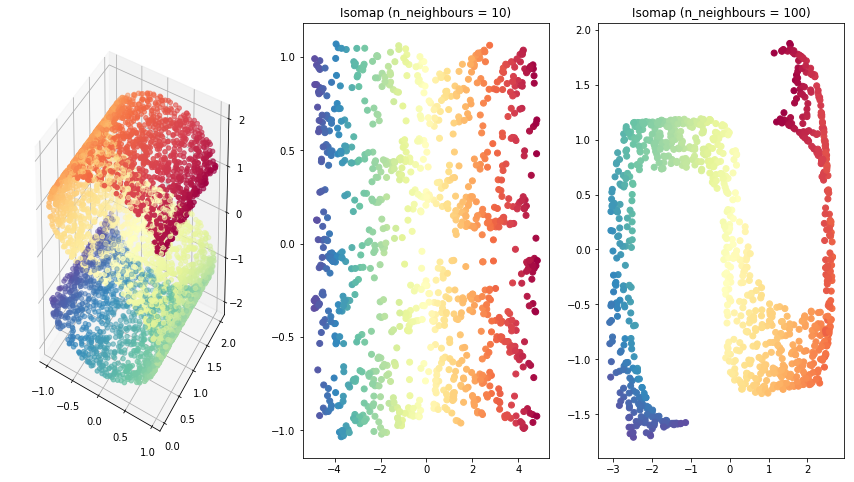

In [4]:
X2, color2 = datasets.samples_generator.make_s_curve(5000, random_state=0)

X, color = datasets.samples_generator.make_s_curve(1000, random_state=0)
Y1 = Isomap(n_neighbors = 10, n_components = 2).fit_transform(X)
Y2 = Isomap(n_neighbors = 100, n_components = 2).fit_transform(X)

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X2[:, 0], X2[:, 1], X2[:, 2], c=color2, cmap=plt.cm.Spectral)

ax = fig.add_subplot(132)
plt.scatter(Y1[:, 0], Y1[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (n_neighbours = 10)")

ax = fig.add_subplot(133)
plt.scatter(Y2[:, 0], Y2[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (n_neighbours = 100)")


# Application to PyRat

We make different tests in two PyRat-datasets that we have generated through our projects: one used for winner prediction and the other one used for playing the game. The first one has 1000 examples where each example represents a map with the initial position of the cheeses; we have the winner of the plays as a label. The second dataset contains all the maps with the position of the cheeses after a movement. In this case we have the move made as a label for each map. 

In [5]:
import tqdm
import numpy as np
import ast
import os


## Dataset of winners

In [31]:
#load dataset
loaded_data = np.load("dataset_winner.npz")
x = loaded_data["x"]
y = loaded_data["y"]

**How does the data in 2 dimensions look like?**

In [9]:
emb_isomap = Isomap(n_neighbors=5, n_components = 2)
x_transformed = emb_isomap.fit_transform(x)
print("Shape of the data after isomap {}".format(x_transformed.shape))


Shape of the data after isomap (1000, 2)


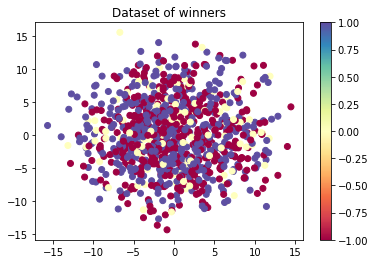

In [15]:
#plot data
plt.scatter(x_transformed[:,0],x_transformed[:,1],
            c = y,label = y, cmap=plt.cm.Spectral)
plt.title("Dataset of winners")
plt.colorbar()

After seeing the results of the previous graph, two questions arise:  

- By means of the isomaps it is possible to see the similarity between the elements within an embedded space, therefore, we wonder if it is possible to see how similar are the examples of a given class.

- On the other hand, as for the reduction of dimensions, in our case a representation is obtained with only two components but which would be the optimal output-dimension? 


# Are the examples to each other similar?

In [22]:
#define a function to make a isomap with different parameters
def toIsomap(x,n, c):
    separator = Isomap(n_neighbors=n, n_components = c)
    return separator.fit_transform(x)
#find classes in dataset

def toLabel(y):
    label = []
    for i in y:
        if i not in label:
            label.append(i)
    return label


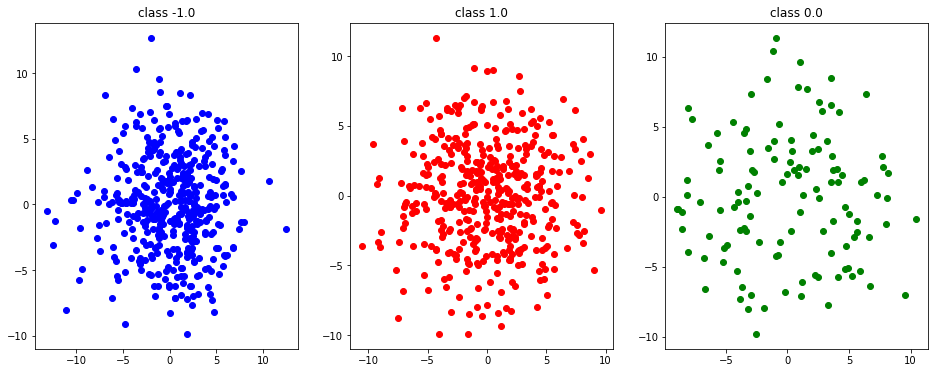

In [59]:
fig = plt.figure(figsize=(16, 6))
winners = toLabel(y) #got labels
colors  = ['b','r','g','y'] 

for c,i in enumerate(winners):
    X = x[y == i] #each move
    x_transformed = toIsomap(X,10,2)
    ax = fig.add_subplot(1,3,c+1) 
    plt.scatter(x_transformed[:,0],x_transformed[:,1],c = colors[c],cmap=plt.cm.Spectral)
    plt.title("class {}".format(i))

We can see that examples from class 0 (draw) are not similar between them (in other words, they don't share a common pattern), that is why it is so difficult to classify them.

# Number of components
## Reconstruction error

According to [Manifold learn Guide](https://scikit-learn.org/stable/modules/manifold.html#isomap) 

The reconstruction error by each routine can be used to choose the optimal output dimension. In our case, the reconstruction error will decrease as `n_components` is increased until `n_components == d`.

`Functions scatter 3D`

In [50]:
from mpl_toolkits.mplot3d import Axes3D

def scatter3D(x,y,number):    
    ax = fig.add_subplot(number, projection='3d')
    
    colors  = ['b','r','g','y']
    labels = toLabel(y)
    n = x.shape[0] ##number
    
    for c,i in zip(labels, colors):
        xs = x[:,0] 
        ys = x[:,1]
        zs = x[:,2]
        
        xs = xs[y == c]
        ys = ys[y == c]
        zs = zs[y == c]
        ax.scatter(xs, ys, zs, c=i)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
plt.show()

Text(0.5, 0.92, 'n_neighbors = 40')

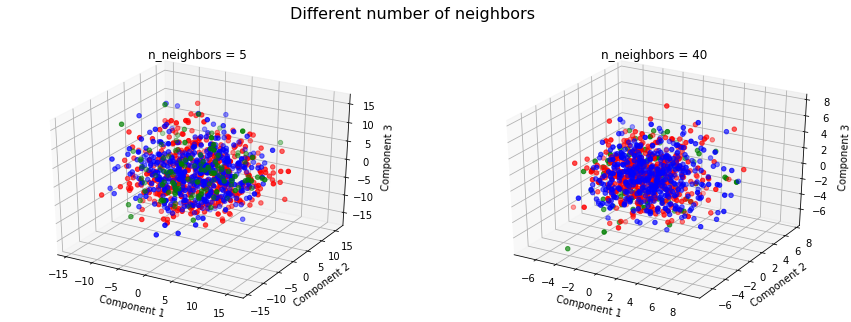

In [83]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Different number of neighbors', fontsize=16)
x_transformed = toIsomap(x,5,3)
scatter3D(x_transformed,y,121)
plt.title('n_neighbors = 5')
x_transformed = toIsomap(x,40,3)
scatter3D(x_transformed,y,122)
plt.title('n_neighbors = 40')

**Note:** 
At this point, as we can see in the graphs, this dataset cannot be easily separated into a lower dimension, however we want to find the dimension that the original data could represent. Let's look at the evolution of the reconstruction error. 

### Evolution of the reconstruction error

In [42]:
rec_error = []
for c in range(1,x.shape[1]):
    emb = Isomap(n_neighbors=5, n_components = c, n_jobs = 2)
    emb.fit_transform(x)
    rec_error.append(emb.reconstruction_error())
    print("Iteration {}/{}".format(c,x.shape[1]))


Iteration 1/315
Iteration 2/315
Iteration 3/315
Iteration 4/315
Iteration 5/315
Iteration 6/315
Iteration 7/315
Iteration 8/315
Iteration 9/315
Iteration 10/315
Iteration 11/315
Iteration 12/315
Iteration 13/315
Iteration 14/315
Iteration 15/315
Iteration 16/315
Iteration 17/315
Iteration 18/315
Iteration 19/315
Iteration 20/315
Iteration 21/315
Iteration 22/315
Iteration 23/315
Iteration 24/315
Iteration 25/315
Iteration 26/315
Iteration 27/315
Iteration 28/315
Iteration 29/315
Iteration 30/315
Iteration 31/315
Iteration 32/315
Iteration 33/315
Iteration 34/315
Iteration 35/315
Iteration 36/315
Iteration 37/315
Iteration 38/315
Iteration 39/315
Iteration 40/315
Iteration 41/315
Iteration 42/315
Iteration 43/315
Iteration 44/315
Iteration 45/315
Iteration 46/315
Iteration 47/315
Iteration 48/315
Iteration 49/315
Iteration 50/315
Iteration 51/315
Iteration 52/315
Iteration 53/315
Iteration 54/315
Iteration 55/315
Iteration 56/315
Iteration 57/315
Iteration 58/315
Iteration 59/315
Iterat

Text(0.5, 1.0, 'Reconstruction Error, Dataset of winners')

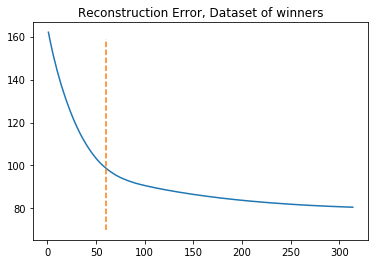

In [45]:
plt.plot(range(1,len(rec_error)+1),rec_error)
plt.plot(60*np.ones(160-70),range(70,160),'--')
plt.title('Reconstruction Error, Dataset of winners')

### Dimension found

By following the approach of the 'elbow-curve', we can see how after the component number `60`, the reconstruction error decreases at a lower rate, so we could use this result as an aproximation of the optimal output dimension.

In [80]:
c = 60
emb = Isomap(n_neighbors=6, n_components = c)
x_data_transform = emb.fit_transform(x)
print(x_data_transform.shape) ##new dataset

(1000, 60)


Shape of the data after isomap (1000, 2)


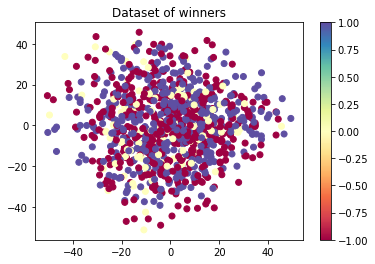

In [81]:
emb_isomap = Isomap(n_neighbors=5, n_components = 2)
x_transformed_60 = emb_isomap.fit_transform(x_data_transform)
print("Shape of the data after isomap {}".format(x_transformed_60.shape))
#plot data
plt.scatter(x_transformed_60[:,0],x_transformed_60[:,1],
            c = y,label = y, cmap=plt.cm.Spectral)
plt.title("Dataset of winners")
plt.colorbar()

In [103]:
rec_error_2 = []
rec_error_60 = []
for c in range(1,40):
    emb = Isomap(n_neighbors=c, n_components = 2, n_jobs = 2)
    emb_60 = Isomap(n_neighbors=c, n_components = 60, n_jobs = 2)
    emb.fit_transform(x)
    emb_60.fit_transform(x)
    rec_error_2.append(emb.reconstruction_error())
    rec_error_60.append(emb_60.reconstruction_error())
    print("Iteration {}/{}".format(c,40))

Iteration 1/40
Iteration 2/40
Iteration 3/40
Iteration 4/40
Iteration 5/40
Iteration 6/40
Iteration 7/40
Iteration 8/40
Iteration 9/40
Iteration 10/40
Iteration 11/40
Iteration 12/40
Iteration 13/40
Iteration 14/40
Iteration 15/40
Iteration 16/40
Iteration 17/40
Iteration 18/40
Iteration 19/40
Iteration 20/40
Iteration 21/40
Iteration 22/40
Iteration 23/40
Iteration 24/40
Iteration 25/40
Iteration 26/40
Iteration 27/40
Iteration 28/40
Iteration 29/40
Iteration 30/40
Iteration 31/40
Iteration 32/40
Iteration 33/40
Iteration 34/40
Iteration 35/40
Iteration 36/40
Iteration 37/40
Iteration 38/40
Iteration 39/40


1
1


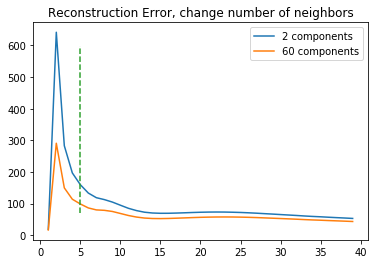

In [108]:
plt.plot(range(1,len(rec_error_2)+1),rec_error_2)
plt.title('Reconstruction Error, change number of neighbors')
print(rec_error_2.index(max(rec_error_2)))
plt.plot(range(1,len(rec_error_60)+1),rec_error_60)
print(rec_error_60.index(max(rec_error_60)))
plt.legend(['2 components','60 components'])
plt.plot(5*np.ones(600-70),range(70,600),'--')

`Number of components: 60`
`Number of neighbors: > 5`

# Dataset of movements

In [109]:
loaded_data = np.load("dataset_moves.npz")
x = loaded_data["x"]
y = loaded_data["y"]

import pickle, scipy
x = scipy.sparse.vstack(x)
x = x.toarray()

y = scipy.sparse.vstack(y).todense()
y = np.argmax(np.array(y),1)
print(x.shape,y.shape)

(59461, 1189) (59461,)


Among the expected problems of Isomap is one related to the time of calculation of the dissimilarity matrix. If N is too big, it becomes impractical. Let's see how it works.

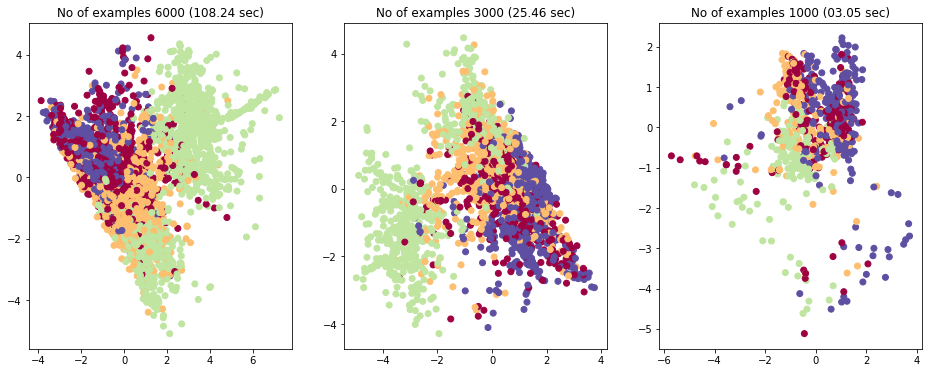

In [113]:
from time import time

fig = plt.figure(figsize=(16, 6))
moves = toLabel(y) #got labels
colors  = ['b','r','g','y'] 
div = [6000,3000,1000]
for c,i in enumerate(div):
    X = x[:i] #select data
    Y = y[:i]
    t0 = time()
    x_t = toIsomap(X,10,2)
    t1 = time()
    ax = fig.add_subplot(1,3,c+1) 
    plt.scatter(x_t[:,0],x_t[:,1],c = Y,cmap=plt.cm.Spectral)
    plt.title("%s %d (%05.2f sec)" % ("No of examples",i, t1 - t0))


# Annexes: Test with representation of 60 dimensions

In [75]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data_transform,y,random_state = 0,test_size=0.2)
 If N is huge, which is true generally in case of big datasets, it becomes impractical.

from sklearn.neighbors import KNeighborsClassifier
k = 1
classifier = KNeighborsClassifier(n_neighbors=k,n_jobs=1)

### CELL TO BE COMPLETED - train the classifier and get the accuracy in both sets.
classifier.fit(x_train,y_train)
print("Accuracy on the training set {}%".format(classifier.score(x_train,y_train)*100))
print("Accuracy on the test set {}%".format(classifier.score(x_test,y_test)*100))  

Accuracy on the training set 100.0%
Accuracy on the test set 47.0%


100%|██████████| 24/24 [00:04<00:00,  4.87it/s]

Best k: 5, Best test accuracy 51.0%
Accuracy on the training set 64.5%
Accuracy on the test set 51.0%


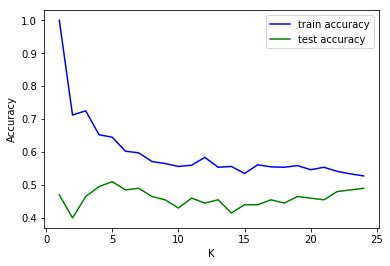

In [76]:
train_acc = list()
test_acc = list() # list to add the test set accuracies
test_ks = range(1,25)# list containing values of k to be tested

# CELL TO BE COMPLETED - Train networks with varying k
for k in tqdm.tqdm(test_ks):
    local_classifier = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    local_classifier.fit(x_train,y_train)
    train_acc.append(local_classifier.score(x_train,y_train))
    test_acc.append(local_classifier.score(x_test,y_test))

plt.plot(test_ks,train_acc,color="blue",label="train accuracy")
plt.plot(test_ks,test_acc,color="green",label="test accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
print("Best k: {}, Best test accuracy {}%".format(test_ks[np.argmax(test_acc)],max(test_acc)*100))


#Retrain the classifier with the best k for the analysis

from sklearn.neighbors import KNeighborsClassifier
k = test_ks[np.argmax(test_acc)]
classifier = KNeighborsClassifier(n_neighbors=k,n_jobs=1)

classifier.fit(x_train,y_train)
print("Accuracy on the training set {}%".format(classifier.score(x_train,y_train)*100))
print("Accuracy on the test set {}%".format(classifier.score(x_test,y_test)*100))

Training Set:
             precision    recall  f1-score   support

       -1.0       0.62      0.80      0.70       364
        0.0       0.49      0.17      0.25       100
        1.0       0.71      0.62      0.66       336

avg / total       0.64      0.65      0.63       800

[[291   7  66]
 [ 63  17  20]
 [117  11 208]]


Text(0,0.5,'Real Class')

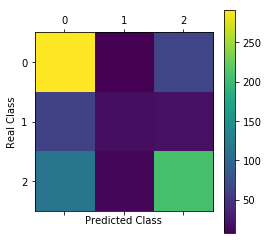

In [77]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_train = classifier.predict(x_train)
report = classification_report(y_true=y_train,y_pred=y_pred_train)
matrix = confusion_matrix(y_true=y_train,y_pred=y_pred_train)
print("Training Set:")
print(report)
print(matrix)
plt.matshow(matrix)
plt.colorbar()

plt.xlabel("Predicted Class")
plt.ylabel("Real Class")